In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
from open_spiel.python.algorithms import random_agent

import sys
sys.path.append("../")
#from utils.reinforcement_learning.dqn_HD import DQN
from utils.reinforcement_learning.dqn import DQN
from utils.params import Params
from utils.evaluation.evaluationhelper import EvaluateModel,EvaluateACTION
from utils.validation import get_Validation, area_under_curve
from utils.environment.game import GraphGame
from utils.environment.envhelper import reset
from utils.reinforcement_learning.rl_environment import Environment

def input_graph(graph_path,file):
    fh = open(graph_path+str(file)+".txt", "rb")
    GRAPH = nx.read_edgelist(fh)
    fh.close()
    nodes = GRAPH.nodes()
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = reset(nx.relabel_nodes(GRAPH, map))  
    GRAPH.remove_edges_from(nx.selfloop_edges(GRAPH))
    return GRAPH, map

def implement_GNN(model,parameter_path,GRAPH):
    params = Params(parameter_path)
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    attacker = DQN(player_id=0,
                    state_representation_size=params.centrality_features,
                    hidden_layers_sizes= params.hidden_layers,
                   global_feature_size =params.global_features,
                   num_actions=num_actions)
    attacker._q_network.load_state_dict(model["_q_network"])
    attacker._optimizer.load_state_dict(model["_optimizer"])
    agents = [attacker]
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    '''agents = [random_agent.RandomAgent(player_id=0, num_actions=num_actions),random_agent.RandomAgent(player_id=1, num_actions=num_actions)]
        rewards_random, lcc_random, _ = eval_model(env, agents)'''
    return rewards, lcc, actions

def implement_random_GNN(agents,GRAPH):
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    return rewards, lcc, actions
    
def implement_Bench(fname,GRAPH, map):
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    action_list = np.loadtxt(fname, dtype=int)
    action_list= [map.get(str(a)) for a in action_list]
    rewards, lcc, actions = EvaluateACTION(env, action_list,GRAPH)
    return rewards, lcc, actions


def visual_evaluation(graph_path,file_list,attacker_ba, attacker_mix,title,plot_grid,grid): 
    if grid[0] * grid[1] < 10:
        figure, axis = plt.subplots(grid[0],grid[1],sharey=True,sharex=True,figsize=(12, 10))
    else :
        figure, axis = plt.subplots(grid[0],grid[1],sharey=True,sharex=True,figsize=(22, 20))
    AUC  = []
    NodeRemoved = []
    model_name = ["MIX","BA","FINDER","CI","COREHD"]
    for i, graph_name in enumerate(file_list):
        GRAPH, map = input_graph(graph_path,graph_name)
        N = len(GRAPH)
        
        # Trained MIXED
        rewards_mix, lcc_mix, actions_mix = implement_GNN(attacker_mix[0],attacker_mix[1],GRAPH.copy())
        # Trained BA
        rewards_ba, lcc_ba, actions_ba = implement_GNN(attacker_ba[0],attacker_ba[1],GRAPH.copy())

        #FINDER MODEl
        #FINDER Best Re-Trained  iteration
        path = "./FINDER/FINDER_ReTrained/"
        fname = path+graph_name+".txt"
        rewards_Finder, lcc_Finder, actions_Finder = implement_Bench(fname,GRAPH.copy(),map)
        if (len(lcc_Finder) == 0):
            lcc_Finder = None
        #CI
        path = "./CI/"
        fname = path+graph_name+".txt"
        rewards_CI, lcc_CI, actions_CI = implement_Bench(fname,GRAPH.copy(),map)
        
        #CoreHD
        path = "./CoreHD/"
        fname = path+graph_name+".txt"
        rewards_CoreHD, lcc_CoreHD, actions_CoreHD =  implement_Bench(fname,GRAPH.copy(),map)
        
        '''#Random
        attacker = random_agent.RandomAgent(player_id=1, num_actions=N)
        rewards_random, lcc_random, actions_random = implement_random_GNN([attacker,attacker],GRAPH.copy())'''

        x =  np.flip(np.arange(N)[N:0:-1]/N)
        
        #Plot LCC Decrease
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_mix)],np.array(lcc_mix)/N, 'green',label='Trained Attacker')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_ba)],np.array(lcc_ba)/N, 'red',label='Trained Attacker [BA model]')
        if lcc_Finder != None:
            axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_Finder)],np.array(lcc_Finder)/N, 'aquamarine',label='FINDER ReTrained')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_CI)],np.array(lcc_CI)/N, 'pink',label='CI')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_CoreHD)],np.array(lcc_CoreHD)/N, 'brown',label='CoreHD')
        axis[plot_grid[i][0],plot_grid[i][1]].set_title(graph_name, fontdict={'fontsize': 18})
        #plt.plot(x[:len(lcc_random)],np.array(lcc_random)/N, 'blue',label='Random')
        #Compute Area under the curve
        auc_mix = area_under_curve(x[:len(lcc_mix)],lcc_mix)
        auc_ba =  area_under_curve(x[:len(lcc_ba)],lcc_ba)
        auc_Finder = area_under_curve(x[:len(lcc_Finder)],lcc_Finder)
        auc_CI = area_under_curve(x[:len(lcc_CI)],lcc_CI)
        auc_CoreHD = area_under_curve(x[:len(lcc_CoreHD)],lcc_CoreHD)
        auc_all = np.array([auc_mix,auc_ba,auc_Finder,auc_CI,auc_CoreHD],dtype='O')
        actions_all = [actions_mix,actions_ba,actions_Finder,actions_CI,actions_CoreHD]
        fractionNode = np.array([len(xi) for xi in actions_all],dtype='O')/N
        AUC.append(np.insert(auc_all,0,graph_name))
        NodeRemoved.append(np.insert(fractionNode,0,graph_name))
        print("AUC",graph_name,model_name[np.argmin(np.array(auc_all,dtype='O'))],np.amin(np.array(auc_all,dtype='O')))
        print("FRACTION",graph_name,model_name[np.argmin(np.array(fractionNode ,dtype='O'))],np.amin(np.array(fractionNode ,dtype='O')))
        print()
    AUC = np.array(AUC)
    np.savetxt("./Figure/Compiled/AUC_"+title+".csv", AUC,delimiter=" & ",newline = "\\\\ \n", fmt=('%s','%f','%f','%f','%f','%f')) 
    NodeRemoved = np.array(NodeRemoved)
    np.savetxt("./Figure/Compiled/Removed_"+title+".csv", NodeRemoved,delimiter=" & ",newline = "\\\\ \n",fmt=('%s','%f','%f','%f','%f','%f')) 
    figure.text(0.5, 0.03,"Fraction of Nodes Removed" , fontsize = 18,  ha='center')
    figure.text(0.04, 0.5, "LCC/No. of Nodes", fontsize = 18,  va='center', rotation='vertical')
    #plt.title("LCC vs No. of Nodes for Agents")
    plt.savefig("./Figure/Compiled/"+title+".pdf")
    plt.show()


# Synthetic Network:- Heterogeneity and Homogeneity

heterogeneous_30
[8, 9, 2, 12, 14, 15, 3, 16]
[3, 8, 12, 14, 15, 1, 9, 16, 2]
AUC heterogeneous_30 BA 3.7391304347826084
FRACTION heterogeneous_30 MIX 0.34782608695652173
heterogeneous_50
[19, 11, 22, 16, 3, 27, 25, 9, 24, 2, 29, 6]
[12, 15, 4, 25, 22, 16, 26, 3, 8, 24, 29, 5]
AUC heterogeneous_50 MIX 5.73611111111111
FRACTION heterogeneous_50 FINDER 0.3055555555555556
heterogeneous_100
[29, 22, 48, 54, 46, 51, 52, 44, 45, 1, 53, 55, 56, 18, 50, 61, 57, 3, 31, 47, 62, 58, 59, 60, 71, 30, 7]
[44, 48, 45, 35, 54, 50, 57, 46, 1, 61, 3, 17, 7, 47, 62, 29, 63, 67, 71, 4, 11]
AUC heterogeneous_100 CI 8.322368421052632
FRACTION heterogeneous_100 FINDER 0.21052631578947367
heterogeneous_500
[301, 302, 303, 304, 308, 313, 315, 316, 318, 331, 332, 338, 320, 321, 322, 286, 324, 325, 98, 283, 383, 284, 287, 285, 333, 288, 309, 349, 306, 225, 358, 218, 38, 50, 246, 247, 230, 339, 39, 28, 300, 150, 326, 352, 136, 109, 244, 198, 385, 152, 386, 281, 387, 195, 103, 41, 388, 148, 319, 245, 0, 334, 91, 2

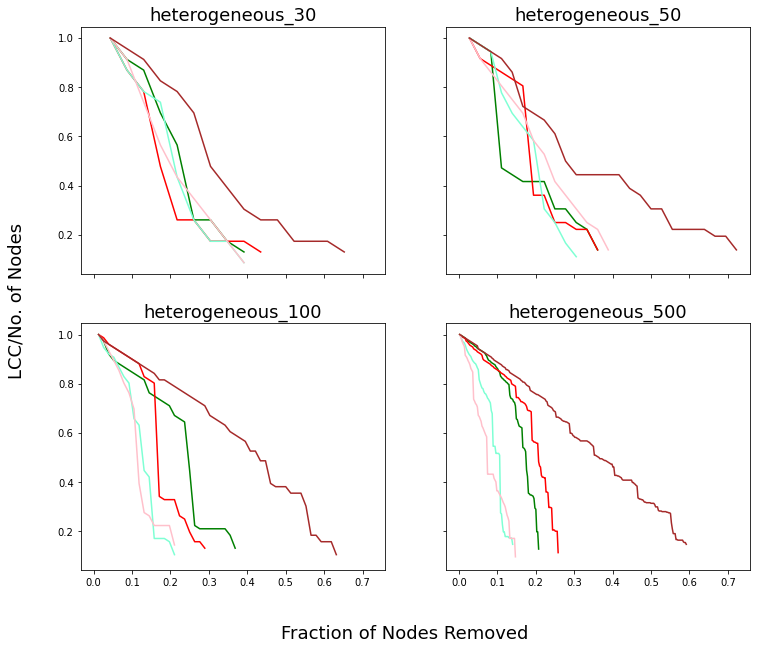

In [49]:
BA =  106500
MIX =  440000 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]
graph_path= "./Dataset/HomogeneityGraph/"
file_list =  ['heterogeneous_30','heterogeneous_50','heterogeneous_100','heterogeneous_500']
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"heterogeneous",[[0,0],[0,1],[1,0],[1,1]],[2,2])


homogeneous_30
[4, 17, 21, 7, 23, 24, 3, 6, 26, 0]
[0, 7, 6, 24, 23, 22, 26, 9, 14, 12, 1, 10, 17]
AUC homogeneous_30 FINDER 5.672413793103449
FRACTION homogeneous_30 MIX 0.3448275862068966
homogeneous_50
[2, 5, 26, 33, 19, 22, 27, 30, 47, 0, 7, 20, 4, 18, 3]
[14, 23, 19, 1, 25, 4, 10, 32, 40, 3, 49, 44, 30, 42, 37, 35, 5]
AUC homogeneous_50 CI 7.59
FRACTION homogeneous_50 FINDER 0.24
homogeneous_100
[4, 60, 61, 80, 66, 67, 79, 5, 82, 2, 77, 53, 72, 35, 6, 64, 13, 11, 18, 29, 10, 49, 14, 31, 93, 69, 73, 22, 15, 23, 7]
[63, 13, 64, 2, 3, 20, 17, 14, 47, 15, 50, 78, 60, 73, 61, 44, 67, 10, 66, 18, 93, 69, 0, 16, 85, 6, 70, 72, 76, 91, 29]
AUC homogeneous_100 FINDER 12.335106382978722
FRACTION homogeneous_100 FINDER 0.23404255319148937
homogeneous_500
[53, 10, 80, 222, 195, 276, 337, 309, 342, 88, 355, 373, 412, 20, 361, 456, 464, 84, 204, 104, 459, 116, 376, 280, 392, 310, 1, 446, 74, 284, 435, 91, 145, 187, 19, 448, 218, 60, 271, 270, 36, 118, 89, 458, 259, 38, 283, 63, 441, 72, 2, 51, 

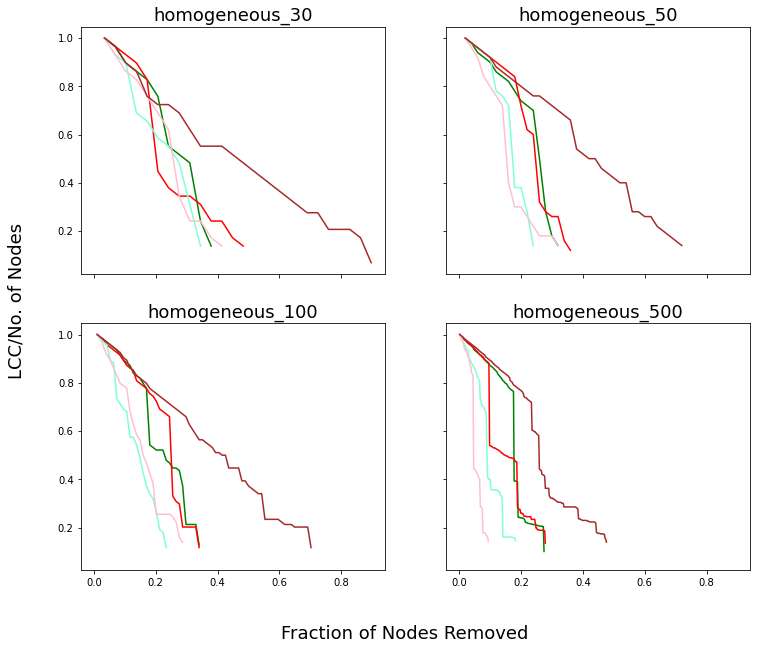

In [50]:

BA = 2500
MIX = 34500 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]
graph_path= "./Dataset/HomogeneityGraph/"
file_list =  ['homogeneous_30','homogeneous_50','homogeneous_100','homogeneous_500']
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"homogeneous",[[0,0],[0,1],[1,0],[1,1]],[2,2])

# Synthetic with Motifs Attached

AUC ba_300_20_house_1 CI 75.61375000000002
FRACTION ba_300_20_house_1 CI 0.2925

AUC ba_300_40_house_2 CI 77.70899999999999
FRACTION ba_300_40_house_2 CI 0.24

AUC ba_300_60_house_3 CI 77.84166666666667
FRACTION ba_300_60_house_3 CI 0.19833333333333333

AUC ba_300_80_house_4 CI 76.97857142857144
FRACTION ba_300_80_house_4 CI 0.17142857142857143

AUC ba_300_100_house_5 CI 79.701875
FRACTION ba_300_100_house_5 CI 0.15875

AUC ba_300_20_fan_1 CI 82.9234375
FRACTION ba_300_20_fan_1 CI 0.3875

AUC ba_300_40_fan_2 CI 79.63676470588236
FRACTION ba_300_40_fan_2 CI 0.34411764705882353

AUC ba_300_60_fan_3 CI 80.98055555555555
FRACTION ba_300_60_fan_3 CI 0.33055555555555555

AUC ba_300_80_fan_4 CI 79.81447368421053
FRACTION ba_300_80_fan_4 CI 0.31842105263157894

AUC ba_300_100_fan_5 CI 77.00374999999998
FRACTION ba_300_100_fan_5 CI 0.2875

AUC ba_300_20_clique_1 CI 76.78073089700995
FRACTION ba_300_20_clique_1 FINDER 0.3687707641196013

AUC ba_300_40_clique_2 FINDER 86.28073089700996
FRACTION b

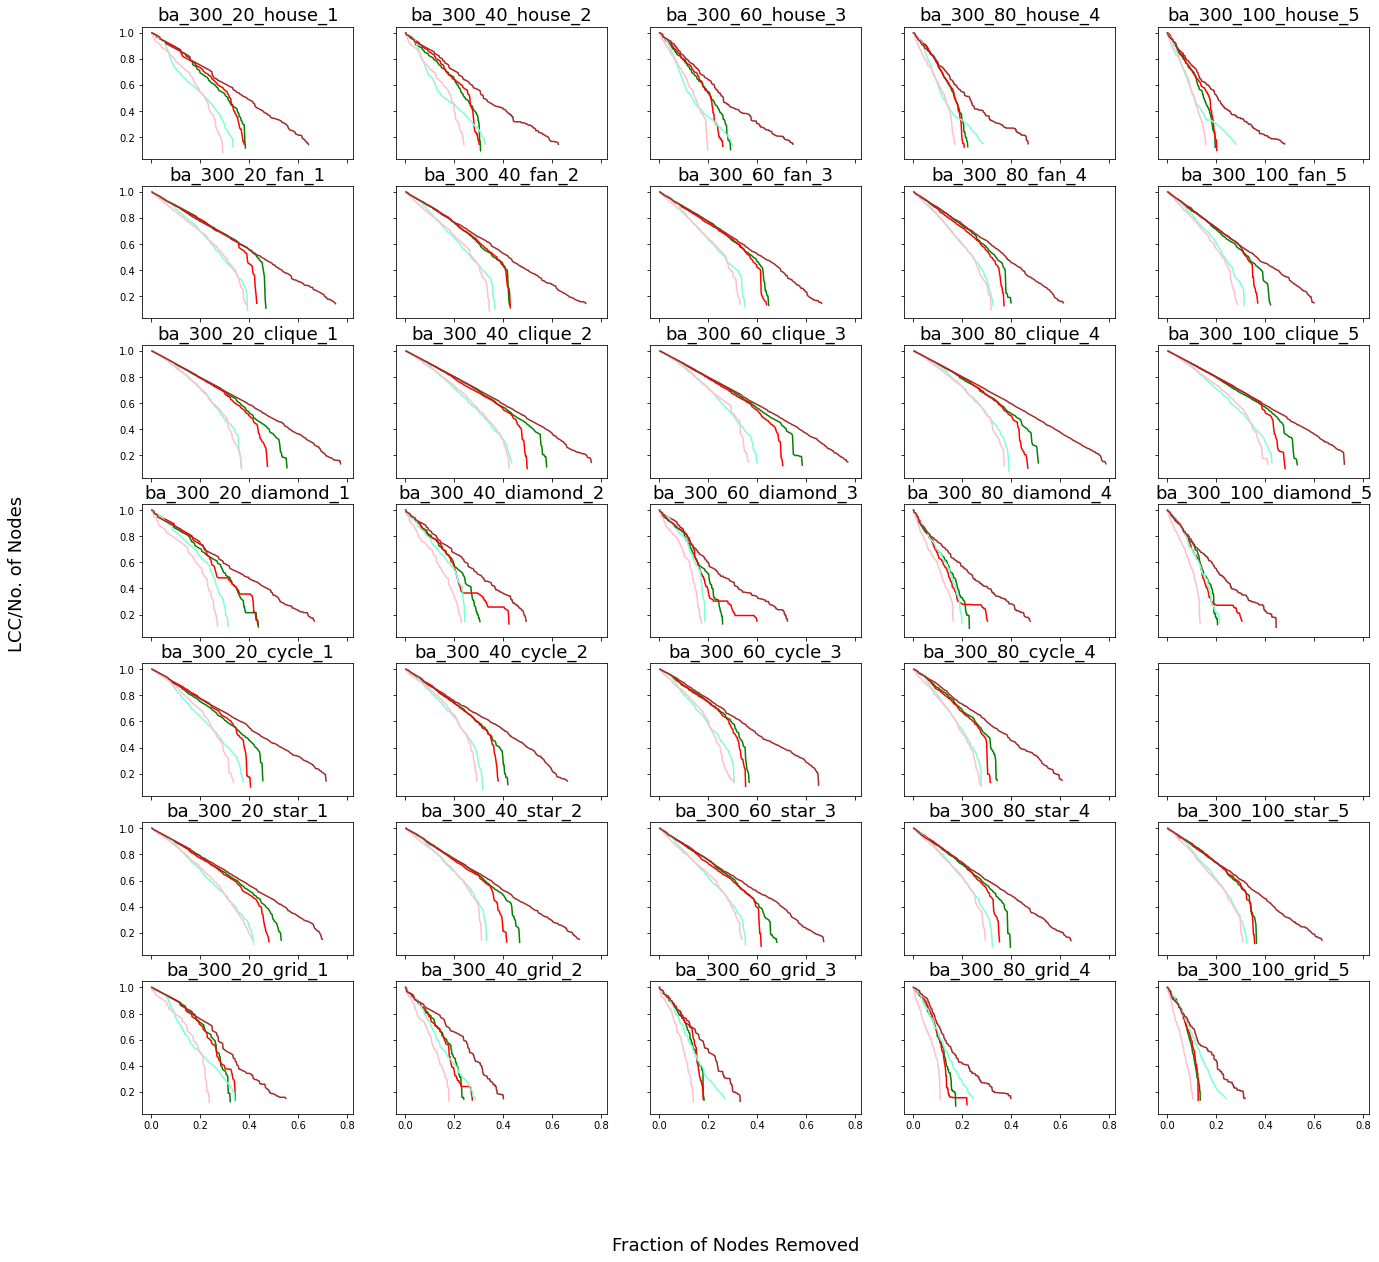

In [53]:
BA =  106500
MIX =  440000 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]
# 'ba_300_100_cycle_5',
file_list = ['ba_300_20_house_1', 'ba_300_40_house_2', 'ba_300_60_house_3', 'ba_300_80_house_4', 'ba_300_100_house_5', 'ba_300_20_fan_1', 'ba_300_40_fan_2', 'ba_300_60_fan_3', 'ba_300_80_fan_4', 'ba_300_100_fan_5', 'ba_300_20_clique_1', 'ba_300_40_clique_2', 'ba_300_60_clique_3', 'ba_300_80_clique_4', 'ba_300_100_clique_5', 'ba_300_20_diamond_1', 'ba_300_40_diamond_2', 'ba_300_60_diamond_3', 'ba_300_80_diamond_4', 'ba_300_100_diamond_5', 'ba_300_20_cycle_1', 'ba_300_40_cycle_2', 'ba_300_60_cycle_3', 'ba_300_80_cycle_4','ba_300_20_star_1', 'ba_300_40_star_2', 'ba_300_60_star_3', 'ba_300_80_star_4', 'ba_300_100_star_5', 'ba_300_20_grid_1', 'ba_300_40_grid_2', 'ba_300_60_grid_3', 'ba_300_80_grid_4', 'ba_300_100_grid_5']
graph_path = "./Dataset/Validation/Motifs_Attached/BA/"
x, y = 7, 5
grid_plot = [[i,j] for i in range(x) for j in range(y)]
grid_plot.pop((5*5 -1))
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"BA_Motifs",grid_plot,[x,y])


AUC tree_8_20_house_1 CI 29.814238952536822
FRACTION tree_8_20_house_1 CI 0.06873977086743044

AUC tree_8_40_house_2 CI 39.904360056258795
FRACTION tree_8_40_house_2 BA 0.08016877637130802

AUC tree_8_60_house_3 CI 44.79963008631319
FRACTION tree_8_60_house_3 MIX 0.08014796547472257

AUC tree_8_80_house_4 CI 59.02689352360044
FRACTION tree_8_80_house_4 BA 0.08562019758507135

AUC tree_8_100_house_5 CI 56.9055390702275
FRACTION tree_8_100_house_5 BA 0.09000989119683482

AUC tree_8_20_fan_1 CI 29.134651600753298
FRACTION tree_8_20_fan_1 CI 0.08097928436911488

AUC tree_8_40_fan_2 MIX 29.35480943738657
FRACTION tree_8_40_fan_2 MIX 0.07259528130671507

AUC tree_8_60_fan_3 MIX 28.664623467600695
FRACTION tree_8_60_fan_3 MIX 0.08056042031523643

AUC tree_8_80_fan_4 MIX 29.203891708967856
FRACTION tree_8_80_fan_4 MIX 0.0727580372250423

AUC tree_8_100_fan_5 FINDER 36.05810147299509
FRACTION tree_8_100_fan_5 FINDER 0.0867430441898527

AUC tree_8_20_clique_1 CI 27.0224609375
FRACTION tree_8_20_

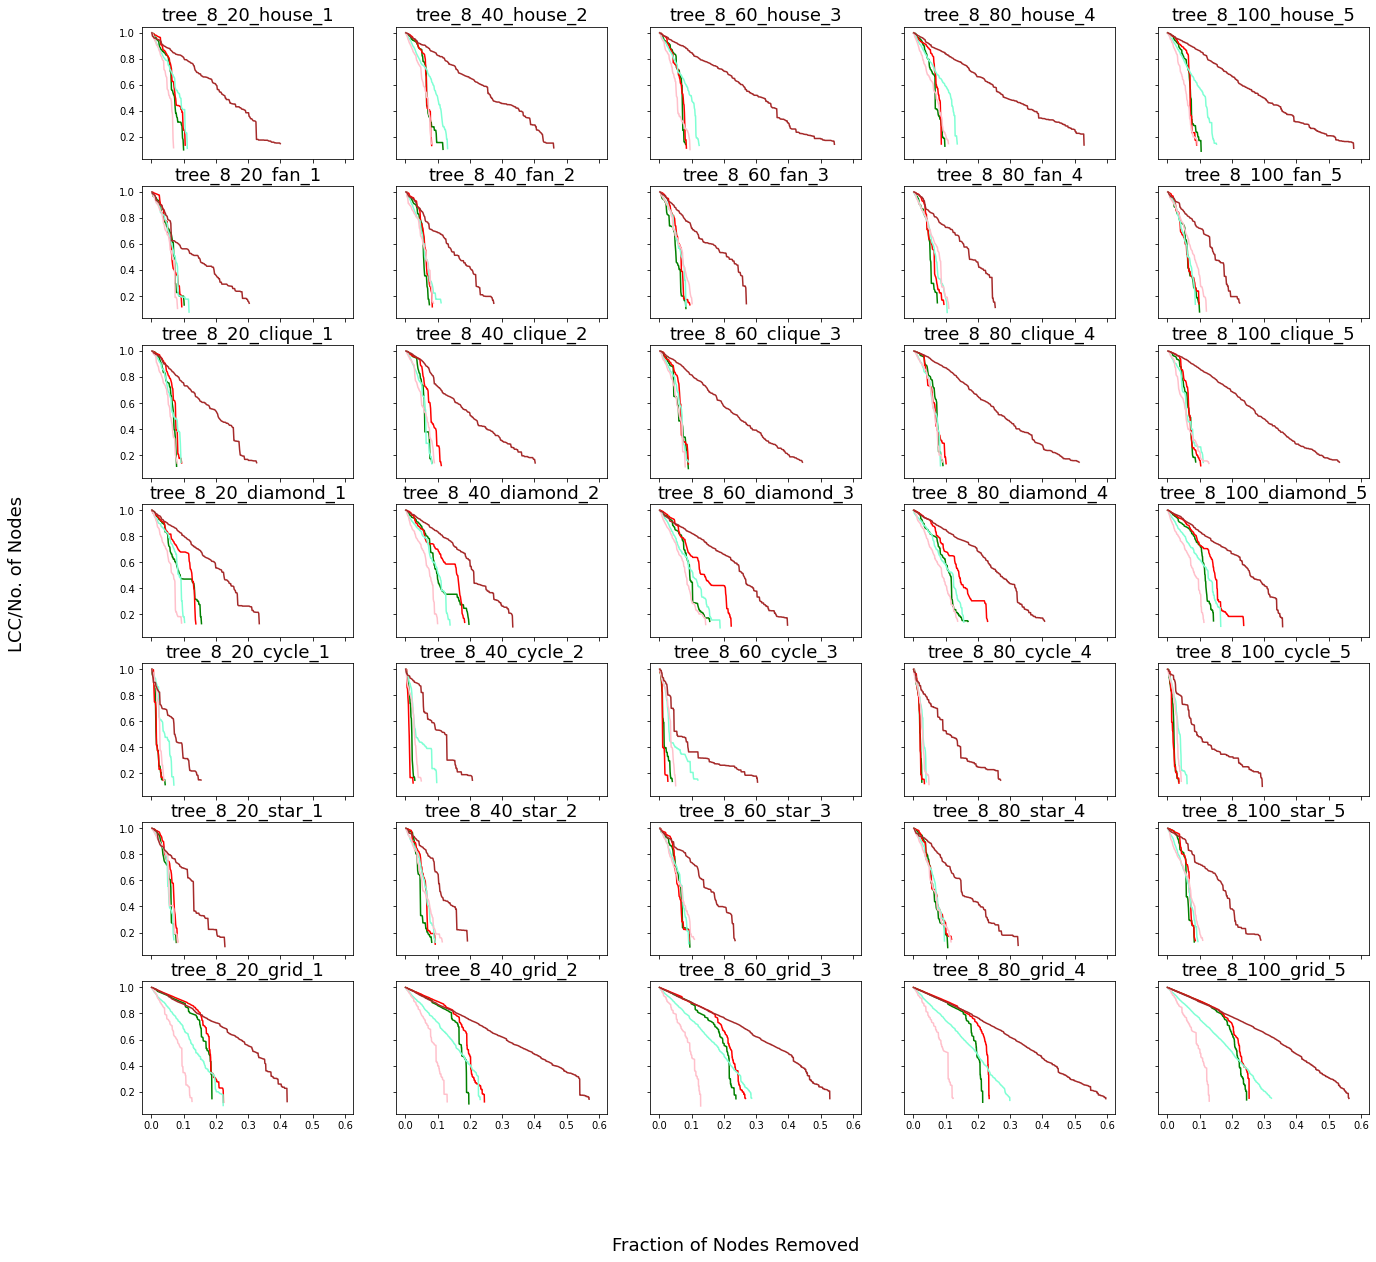

In [54]:
BA =  106500
MIX =  440000 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]
file_list = ['tree_8_20_house_1', 'tree_8_40_house_2', 'tree_8_60_house_3', 'tree_8_80_house_4', 'tree_8_100_house_5', 'tree_8_20_fan_1', 'tree_8_40_fan_2', 'tree_8_60_fan_3', 'tree_8_80_fan_4', 'tree_8_100_fan_5', 'tree_8_20_clique_1', 'tree_8_40_clique_2', 'tree_8_60_clique_3', 'tree_8_80_clique_4', 'tree_8_100_clique_5', 'tree_8_20_diamond_1', 'tree_8_40_diamond_2', 'tree_8_60_diamond_3', 'tree_8_80_diamond_4', 'tree_8_100_diamond_5', 'tree_8_20_cycle_1', 'tree_8_40_cycle_2', 'tree_8_60_cycle_3', 'tree_8_80_cycle_4', 'tree_8_100_cycle_5', 'tree_8_20_star_1', 'tree_8_40_star_2', 'tree_8_60_star_3', 'tree_8_80_star_4', 'tree_8_100_star_5', 'tree_8_20_grid_1', 'tree_8_40_grid_2', 'tree_8_60_grid_3','tree_8_80_grid_4', 'tree_8_100_grid_5']
graph_path ="./Dataset/Validation/Motifs_Attached/Tree/" 
x, y = 7, 5
grid_plot = [[i,j] for i in range(x) for j in range(y)]
#[print(i,file_list[i],grid_plot[i][0],grid_plot[i][1]) for i in range(x*y)]
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Tree_Motifs",grid_plot,[x,y])


AUC corruption FINDER 13.432038834951456
FRACTION corruption FINDER 0.06796116504854369

AUC foodweb-baywet CI 46.4296875
FRACTION foodweb-baywet CI 0.5625

AUC inf-USAir97 CI 33.92620481927711
FRACTION inf-USAir97 MIX 0.1716867469879518

AUC moreno_crime_projected CI 16.446949602122015
FRACTION moreno_crime_projected MIX 0.042440318302387266

AUC opsahl-openflights CI 179.93228989452194
FRACTION opsahl-openflights CI 0.10547805375978224

AUC household CI 91.96634093376764
FRACTION household CI 0.18783930510314875

AUC faa CI 106.24184339314846
FRACTION faa CI 0.13376835236541598

AUC facebook FINDER 1.8829639889196677
FRACTION facebook FINDER 0.0017313019390581717

AUC powergrid CI 173.17233353572152
FRACTION powergrid CI 0.060109289617486336

AUC netscience CI 2.829911019849418
FRACTION netscience CI 0.019164955509924708

AUC HI-II-14 CI 210.8194477791116
FRACTION HI-II-14 CI 0.09555822328931572



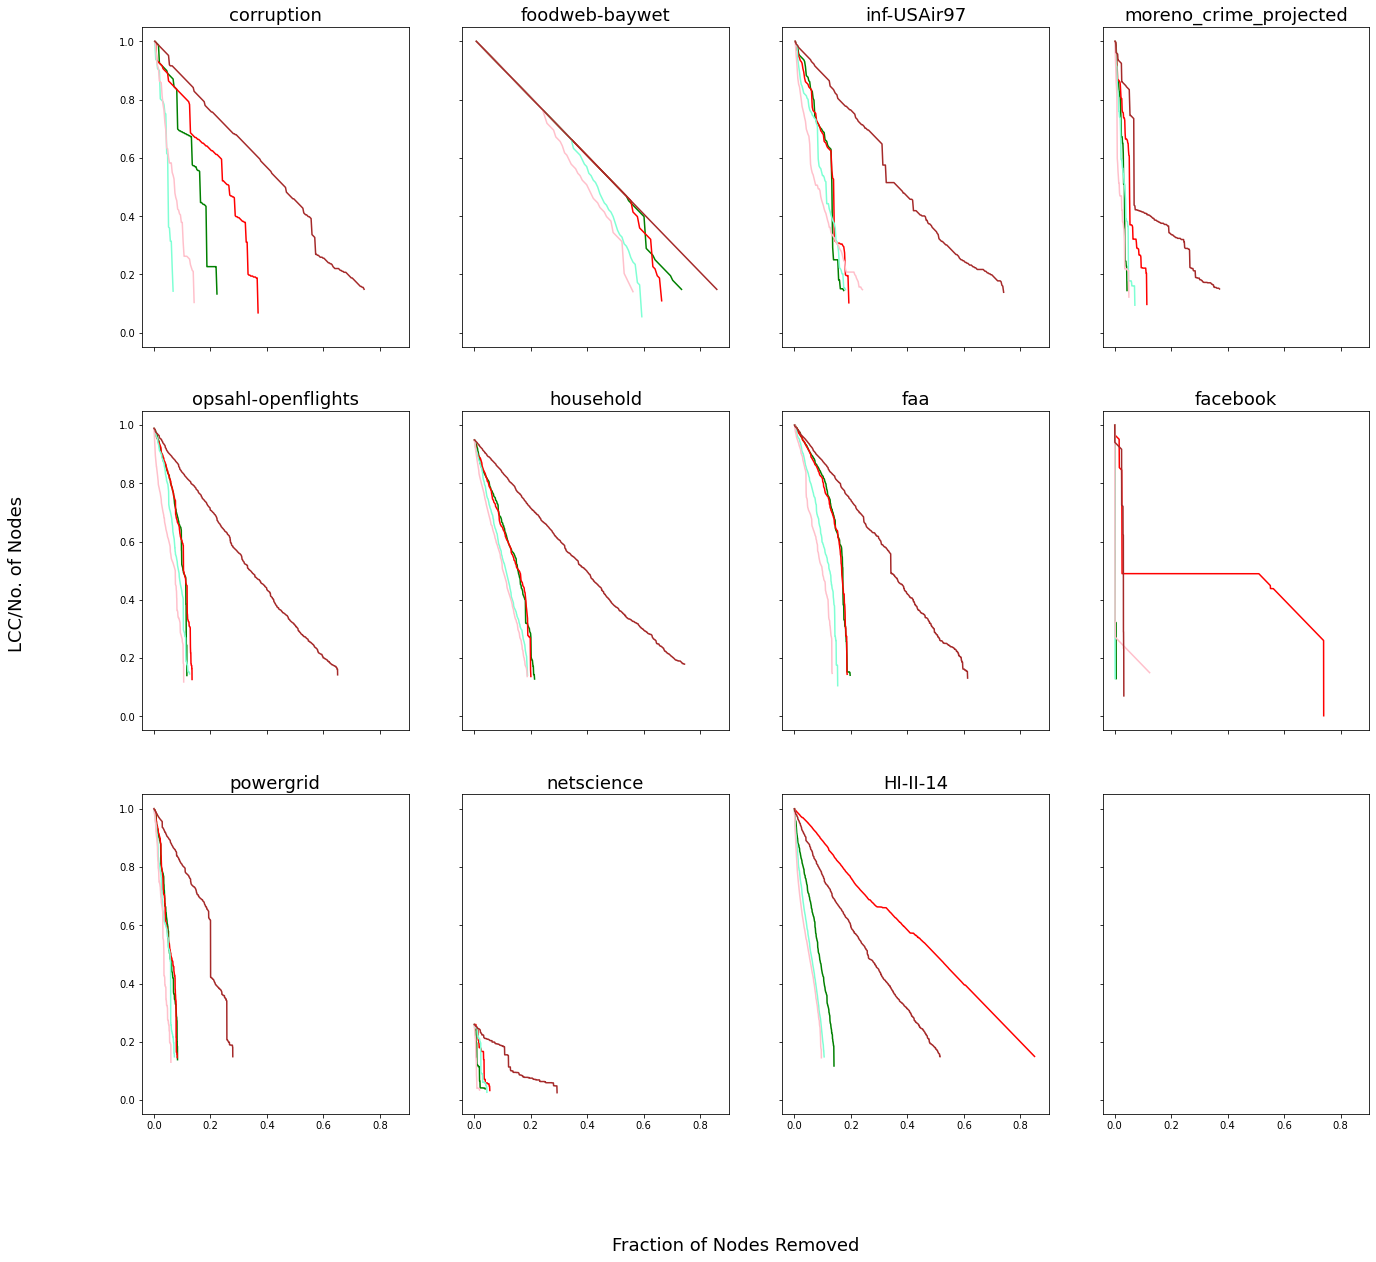

In [55]:
BA =  106500
MIX =  440000 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]
file_list = ["corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected",'opsahl-openflights','household','faa','facebook','powergrid','netscience','HI-II-14']
graph_path =  "./Dataset/Real/"
x, y = 3, 4
grid_plot = [[i,j] for i in range(x) for j in range(y)]
#[print(i,file_list[i],grid_plot[i][0],grid_plot[i][1]) for i in range(x*y)]
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Real",grid_plot,[x,y])


## Cancer Gene

In [ ]:
BA =  106500
MIX =  440000 
graph_path = "./Dataset/GeneNetwork/"
file_list =  ["COAD","HNSC","KICH","PRAD","UCEC"]
x, y = 2, 3
grid_plot = [[i,j] for i in range(x) for j in range(y)]
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Cancer_Gene",grid_plot,[x,y])